In [2]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from collections import Counter
from collections import defaultdict # import defaultdict from collections module
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
path="https://sites.stat.washington.edu/courses/stat527/s14/homework/hw5/spam.data"


In [3]:
class Node:
    def __init__(self, impurity, num_samples, num_samples_per_class, predicted_class):
        self.impurity = impurity  # Entropy or Gini impurity of the node
        self.num_samples = num_samples  # Total samples in the node
        self.num_samples_per_class = num_samples_per_class  # Number of samples per class in the node
        self.predicted_class = predicted_class  # Class with max samples in this node
        self.feature_index = 0  # Index of feature for splitting
        self.threshold = 0  # Threshold for splitting
        self.left = None  # Left child node
        self.right = None  # Right child node

class DecisionTree:
    def __init__(self, max_depth=None,max_features=None):
        self.max_depth = max_depth
        self.tree = None
        self.max_features = max_features
        # self.root = Node()

    def fit(self, X, y):
        # Implement your decision tree fitting method
        pass

    def predict_tree(self,node, X):
      """Make a prediction for a single sample."""
      while node.left:
          if X[node.feature_index] < node.threshold:
              node = node.left
          else:
              node = node.right
      return node.predicted_class

    def split_dataset(self,X, y, feature_index, threshold):
        """Split the dataset based on the feature index and threshold."""
        left = X[:, feature_index] < threshold
        right = ~left
        return X[left], y[left], X[right], y[right]

    def entropy(self,y):
        """Calculate the entropy for a list of classes."""
        m = len(y)
        if m == 0:
            return 0

        unique_values, counts = np.unique(y, return_counts=True)
        class_counts = dict(zip(unique_values, counts))
        # print("class counts:",class_counts)

        # class_counts = np.bincount(y)
        probabilities = np.array(list(class_counts.values()))[np.array(list(class_counts.values())) > 0] / m  # Correct way to filter for dictionary values
        # print("probabilities",probabilities)

        return -np.sum(probabilities * np.log2(probabilities))

        probabilities = class_counts[class_counts > 0] / m
        return -np.sum(probabilities * np.log2(probabilities))

    def best_split(self, X, y):
      # Initialize best parameters
      best_feature, best_threshold, best_gain = None, None, -np.inf
      base_entropy = self.entropy(y)  # Entropy before the split
      n_samples, n_features = X.shape

      feature_indices = np.random.choice(n_features, self.max_features, replace=False)
      # print("feature_indices:",feature_indices)

      for feature_index in feature_indices:
      # for feature_index in range(n_features):
          # Get unique thresholds to try for this feature
          thresholds = np.unique(X[:, feature_index])

          for threshold in thresholds:
              # Partition the data based on the threshold
              left_mask = X[:, feature_index] <= threshold
              right_mask = ~left_mask  # Inverse of left mask

              if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                  continue  # Skip if split results in an empty partition

              # Calculate entropies of the partitions
              left_entropy = self.entropy(y[left_mask])
              right_entropy = self.entropy(y[right_mask])

              # Weighted average of the entropy after the split
              left_weight = np.sum(left_mask) / n_samples
              right_weight = np.sum(right_mask) / n_samples
              weighted_entropy = left_weight * left_entropy + right_weight * right_entropy

              # Calculate information gain
              gain = base_entropy - weighted_entropy

              # Update the best split if we have found a better gain
              if gain > best_gain:
                  best_gain = gain
                  best_feature = feature_index
                  best_threshold = threshold

      return best_feature, best_threshold

    # def best_split(self, X, y):
    #     """Find the best feature and threshold to split the dataset."""
    #     best_impurity = float("inf")  # Start with maximum impurity
    #     best_index, best_threshold = None, None
    #     m, n_features = X.shape

    #     for feature_index in range(n_features):
    #         thresholds, classes = zip(*sorted(zip(X[:, feature_index], y)))
    #         num_left = [0] * 2
    #         num_right = [np.sum(classes == c) for c in np.unique(y)]

    #         for i in range(1, m):
    #             c = classes[i - 1]
    #             print("c:",c)
    #             num_left[c] += 1
    #             num_right[c] -= 1
    #             entropy_left = self.entropy(np.array(classes[:i]))
    #             entropy_right = self.entropy(np.array(classes[i:]))
    #             impurity = (i * entropy_left + (m - i) * entropy_right) / m

    #             if thresholds[i] == thresholds[i - 1]:
    #                 continue

    #             if impurity < best_impurity:
    #                 best_impurity = impurity
    #                 best_index = feature_index
    #                 best_threshold = (thresholds[i] + thresholds[i - 1]) / 2

    #     return best_index, best_threshold

    def build_tree(self,X, y, depth=0, max_depth=10):
      """Recursively build a decision tree."""
      num_samples_per_class = [np.sum(y == i) for i in np.unique(y)]
      predicted_class = np.argmax(num_samples_per_class)
      node = Node(
          impurity=self.entropy(y),
          num_samples=len(y),
          num_samples_per_class=num_samples_per_class,
          predicted_class=predicted_class,
      )

      if depth < max_depth:
          index, threshold = self.best_split(X, y)
          if index is not None:
              X_left, y_left, X_right, y_right = self.split_dataset(X, y, index, threshold)
              if len(X_left) > 0 and len(X_right) > 0:
                  node.feature_index = index
                  node.threshold = threshold
                  node.left = self.build_tree(X_left, y_left, depth + 1, max_depth)
                  node.right = self.build_tree(X_right, y_right, depth + 1, max_depth)
      return node

class RandomForest:
    def __init__(self, n_trees=100, max_depth=None, min_samples_split=2, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
        self.oob_predictions = defaultdict(list)  # Store OOB predictions
        self.oob_score_ = None

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        oob_indices = list(set(range(n_samples)) - set(indices))


        # print("indices:",indices)
        return X[indices], y[indices], oob_indices

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            # tree = DecisionTree(max_depth=self.max_depth)
            X_sample, y_sample, oob_indices = self._bootstrap_sample(X, y)

            decision_tree=DecisionTree(max_features=self.max_features)
            # print("random set size:",self.max_features)
            # tree.fit(X_sample, y_sample
            tree = decision_tree.build_tree(X_sample, y_sample, max_depth=10)
            # y_pred = [decision_tree.predict_tree(tree, x) for x in X_test]

            # tree.fit(X_sample, y_sample)
            self.trees.append([decision_tree,tree])

            # oob_predictions = tree.predict(X[oob_indices])
            oob_predictions = [decision_tree.predict_tree(tree, x) for x in X[oob_indices]]  # Changed line


            for idx, pred in zip(oob_indices, oob_predictions):
                self.oob_predictions[idx].append(pred)

        self.calculate_oob_score(y)
        return self.oob_score_

    def calculate_oob_score(self, y):
        oob_correct = 0
        oob_total = 0

        # Aggregate predictions for each OOB sample
        for idx, preds in self.oob_predictions.items():
            if len(preds) > 0:
                # Majority vote for classification
                final_pred = Counter(preds).most_common(1)[0][0]
                if final_pred == y[idx]:
                    oob_correct += 1
                oob_total += 1

        # Calculate the OOB accuracy
        self.oob_score_ = oob_correct / oob_total if oob_total > 0 else None
        print(f"OOB Score: {self.oob_score_}")

    def predict(self, X_test):
        # y_pred = [decision_tree.predict_tree(tree, x) for x in X_test]
        # print("thisssss:",[x for x in X_test])
        # [(tree.predict_tree(root,X) ) for tree,root in  my_rf.trees]
        tree_predictions=[]
        for tree,root in self.trees:
          y_pred = [tree.predict_tree(root, x) for x in X_test]
          tree_predictions.append(y_pred)
          pass

        # tree_predictions = np.array([tree.predict_tree(root,X) for tree,root in self.trees])
        # Majority voting
        # tree_predictions = list(zip(*tree_predictions))
        tree_predictions = np.array(tree_predictions)

        return [Counter(tree_predictions[:, i]).most_common(1)[0][0] for i in range(X_test.shape[0])]


In [4]:
data = np.loadtxt(path)

# Separate features (X) and labels (y)
X = data[:, :-1]  # All columns except the last one for features
y = data[:, -1]   # Last column for labels

# Split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)



Training data shape: (3220, 57)
Test data shape: (1381, 57)
Training labels shape: (3220,)
Test labels shape: (1381,)



OOB Score: 0.9041512714627254
My Random Forest Accuracy: 0.9116582186821144
Scikit-Learn Random Forest Accuracy: 0.9333816075307748

In [5]:
# Train your Random Forest
# for set_size in range(int(np.sqrt(X_train.shape[1]))):
# for n_trees in range(10,150,10):
#   print("n_trees",n_trees)
# for set_size in range(10,X_train.shape[1],10):
#   print("set size",set_size)
#   # my_rf = RandomForest(n_trees=100, max_depth=10, max_features=set_size)
my_rf = RandomForest(n_trees=100, max_depth=10, max_features=30)
oob_error=my_rf.fit(X, y)
# my_rf.fit(X_train, y_train)
y_pred = my_rf.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"My Random Forest Accuracy: {accuracy}")

# Compare with Scikit-Learn
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=10, max_features='sqrt')
clf.fit(X_train, y_train)
print(f"Scikit-Learn Random Forest Accuracy: {clf.score(X_test, y_test)}")


OOB Score: 0.9006737665724842
My Random Forest Accuracy: 0.9109341057204924
Scikit-Learn Random Forest Accuracy: 0.939174511223751


**5: Random Forest **



#5B:  Test Accuracy Plot:
A similar pattern is expected for test accuracy: as max_features increases, accuracy may initially improve but could plateau or even decrease with too many features due to overfitting.


#5C: OOB Error Plot:

Typically, as max_features increases, the OOB error may initially decrease as more features allow for better splits and more complex decision boundaries.
After a certain point, the OOB error may plateau or increase slightly, as too many features can introduce noise or redundancy, which doesn’t improve model performance.

```
Following Graph plots the relationship between accuracy and Number of parameters
```

In [6]:
# m_values = [50]
m_values = [10, 20, 30, 40,50]


oob_errors = []
test_errors = []

for m in m_values:
    # Initialize RandomForest with current value of m (max_features)
    my_rf = RandomForest(n_trees=100, max_depth=10, max_features=m)

    # Train the model and get the OOB error
    oob_error = my_rf.fit(X_train, y_train)  # Assume fit returns OOB error
    oob_errors.append(oob_error)

    # Predict on the test set and calculate test error
    y_pred = my_rf.predict(X_test)
    test_error = 1 - accuracy_score(y_test, y_pred)
    test_errors.append(test_error)



OOB Score: 0.9145962732919255


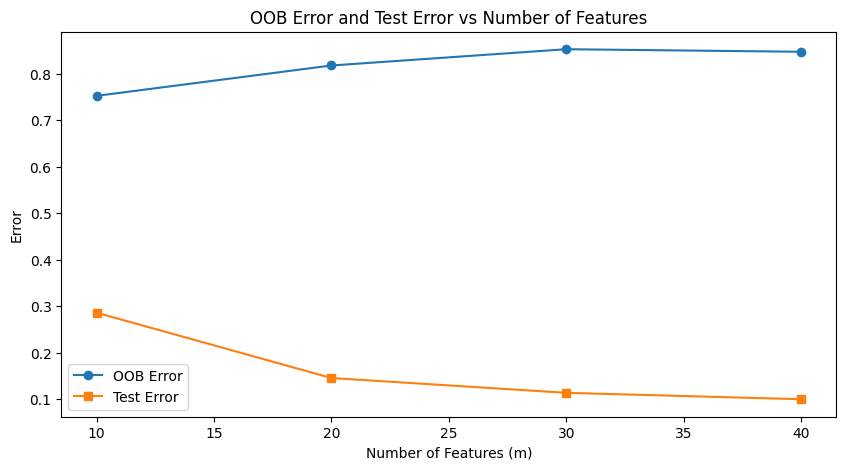

In [20]:

# Plotting OOB error and Test error
plt.figure(figsize=(10, 5))
plt.plot(m_values, oob_errors, label="OOB Error", marker='o')
plt.plot(m_values, test_errors, label="Test Error", marker='s')
plt.xlabel("Number of Features (m)")
plt.ylabel("Error")
plt.title("OOB Error and Test Error vs Number of Features")
plt.legend()
plt.show()